<center>
    
# [Компьютерное зрение](https://cogmodel.mipt.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5)

## <center> Семинар 5

<a target="_blank" href="https://colab.research.google.com/github/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_05/Seminar_5.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

***

In [165]:
from pathlib import Path

import cv2

import matplotlib.pyplot as plt

# О датасете

В рамках данного семинара предлагается поработать с изображениями с конкурса по анализу данных Proppant Check Challenge. Описание задачи и данных можно посмотреть на сайте соревнования: https://boosters.pro/championship/RPCC

Ранее можно было скачать весь датасет https://boosters.pro/api/ch/files/pub/RPCC_train.zip, однако по состоянию на 01.02.2023 эта ссылка возвращает 404. Однако для выполнения данного задания весь датасет и не нужен, достаточно будет "чудом уцелевшего" изображения `./data/rpcc_sample.png` (его разрешение ниже, чем в оригинальном датасете, но на общий ход решения это не влияет).

In [166]:
# !wget https://boosters.pro/api/ch/files/pub/RPCC_train.zip

In [167]:
IMG_PATH = "data/rpcc_sample.png"
TEMPLATE_PATH = "data/rpcc_template.png"

if not Path(IMG_PATH).exists() or not Path(TEMPLATE_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_05/data .

# Работа с изображением

Основным заданием будет создание алгоритма предобработки изображений для решения следующей задачи:

**Входные данные:** фотография листа бумаги с нанесенным шаблоном и рассыпанным пропаннатом

**Выходные данные:** кроп входного изображения, содержащего только область с проппанатом.

In [168]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Изображения в датасете сняты на камеру мобильного телефона под некоторым углом и с некоторого расстояния:

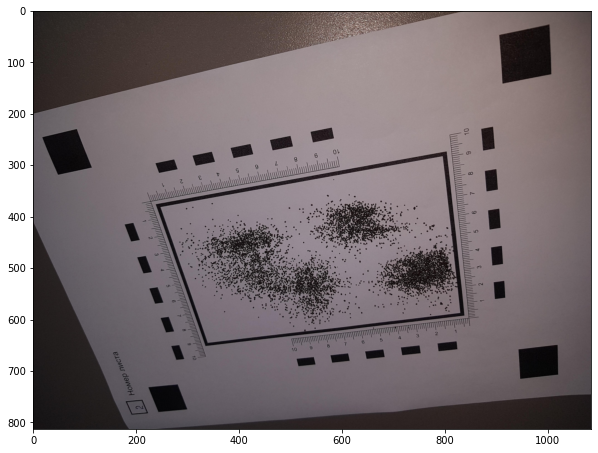

In [169]:
plt.figure(figsize=[10, 10])
plt.imshow(img)

На всех фотографиях снят лист бумаги с распечатанным шаблоном и рассыпанным на нем проппанатом. Шаблон извествен:

In [170]:
template = cv2.imread(TEMPLATE_PATH)

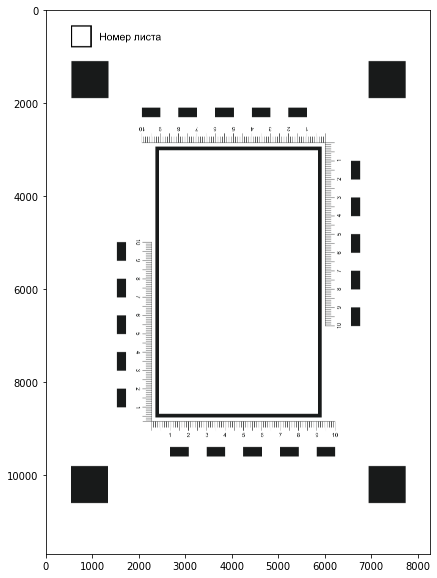

In [171]:
plt.figure(figsize=[15, 10])
plt.imshow(template)

Далее рассмотрим примеры использования алгоритмов, которые могут быть полезны при решении данной задачи извлечения области с проппанатом.

## Бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Реализация обычной пороговой бинаризации в OpenCV представлена функцией `cv2.threshold` с флагом `cv2.THRESH_BINARY`. Другие флаги, такие как `cv2.THRESH_TRUNC`
`cv2.THRESH_TOZERO` определяют, будут ли изменены значения ниже или выше порога

In [172]:
ret, th_const = cv2.threshold(
    gray,                   # входное изображение
    128,                    # порог бинаризации
    255,                    # максимальное значения пикселя изображения
    cv2.THRESH_BINARY       # способ бинаризации (cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV)
)

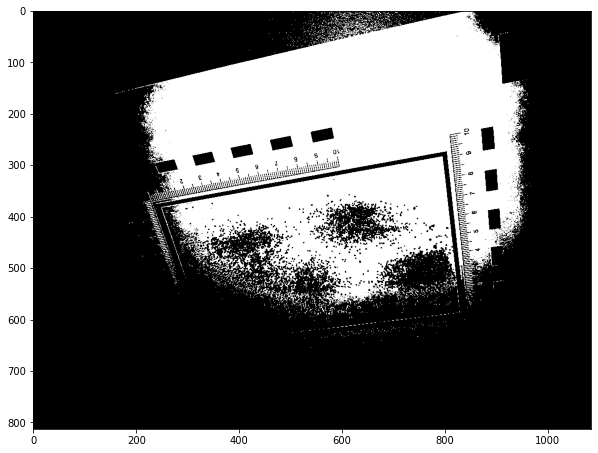

In [173]:
plt.figure(figsize=[10, 10])
plt.imshow(th_const, cmap='Greys_r')

## Вопрос 1

В чем заключается недостаток обычной бинаризации по константному порогу?

**Ответ:Нет учета градиента освещения** 

Очевидно, что результат неудовлетворителен. Впрочем, можно попробовать подобрать оптимальный порог вручную, основываясь на визуальной оценке качества бинаризации, или осуществить поиск оптимального порога по **методу Отсу**. Делается это передачей дополнительного флага `cv2.THRESH_OTSU`:

In [174]:
ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [175]:
print('Оптимальный порог бинаризации по Отсу: ', ret)

Оптимальный порог бинаризации по Отсу:  80.0


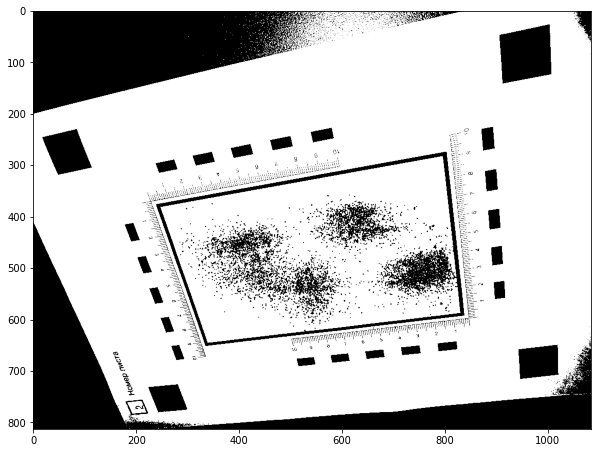

In [176]:
plt.figure(figsize=[10, 10])
plt.imshow(th_otsu, cmap='Greys_r')

Уже значительно лучше. Но попробуем адаптивную бинаризацию

## Адаптивная бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Адаптивная бинаризация в OpenCV представлена методом `cv2.adaptiveThreshold`:

In [177]:
th_adaptive = cv2.adaptiveThreshold(
    gray,                        # входное изображение
    255,                         # максимальное значения пикселя изображения
    cv2.ADAPTIVE_THRESH_MEAN_C,  # способ вычисления порога (cv2.ADAPTIVE_THRESH_MEAN_C - среднее, cv.ADAPTIVE_THRESH_GAUSSIAN_C - взвешенное среднее, с весами по гауссиане)
    cv2.THRESH_BINARY,           # способ бинаризации (те же, что и для неадаптивной)
    51,                           # размер окрестности пикселя, рассматриваемой при вычислении порога (должна быть нечетной)
    0                            # это значение вычитается из вычисленного порога, полученная величина - фактический порог бинаризации
)

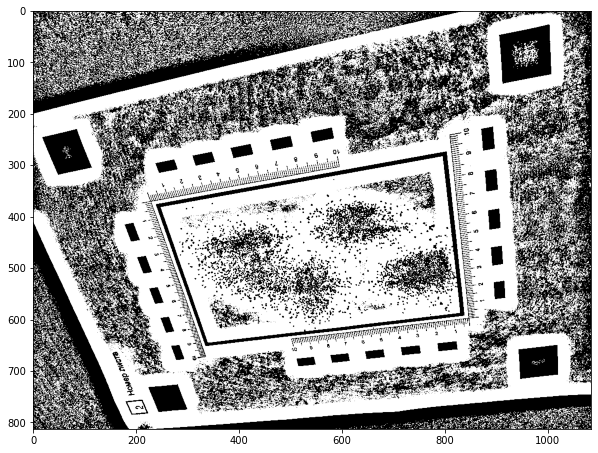

In [178]:
plt.figure(figsize=[10, 10])
plt.imshow(th_adaptive, cmap='Greys_r')

Получилось не очень, но, возможно, поможет подбор параметров!

## Вопрос 2

Исходя из результатов работы адаптивной бинаризации, попробуйте определить, какие характеристики исходного изображения могли привести к таким результатам? Другими словами, устойчивость к каким характеристикам входных данных требуется повысить с помощью варьирования параметров или применения дополнительных методов для того, чтобы улучшить результат?

**Ответ:Входное изображение представляет собой зашумленное изображение. Изображение сначала необходимо фильтровать для удаления шума, затем применяется пороговое значение Otsu.**

## Морфологические преобразования

Туториал: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

Попробуем 'очистить' результаты адаптивной бинаризации, сохранив только ярко выраженные границы. Достигнуть этого можно с помощью морфологического преобразования 'opening' (открытия, раскрытия):

In [179]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
th_adaptive_cl = cv2.morphologyEx(th_adaptive, cv2.MORPH_CLOSE, kernel, None, None, 2)
print('Ядро морфологической операции:\n\n', kernel)

Ядро морфологической операции:

 [[0 1 0]
 [1 1 1]
 [0 1 0]]


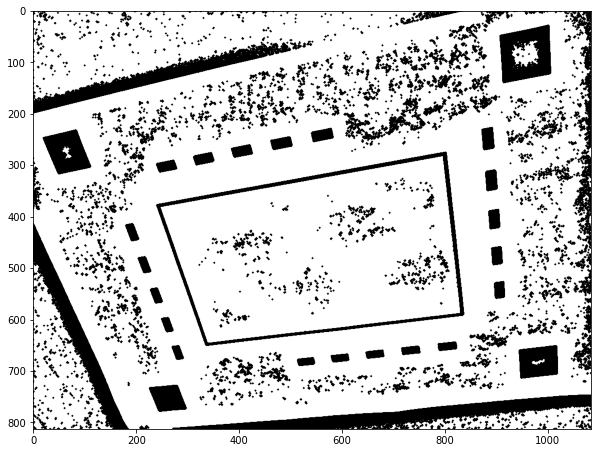

In [180]:
plt.figure(figsize=[10, 10])
plt.imshow(th_adaptive_cl, cmap='Greys_r')

## Выделение границ

Туториал: https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

Для выделения границ наиболее популярным является метод Канни:

In [181]:
edges = cv2.Canny(
    th_otsu,    # входное изображение
    100,        # нижний порог гистерезиса
    200,        # верхний порог гистерезиса
    None,       # буфер для ребер, укажем None, так как воспользуемся возвращаемым значением
    3,          # размер ядра дифференциального оператора Собеля
    True        # False/True L1/L2 норма для вичисления отклика по производным
)

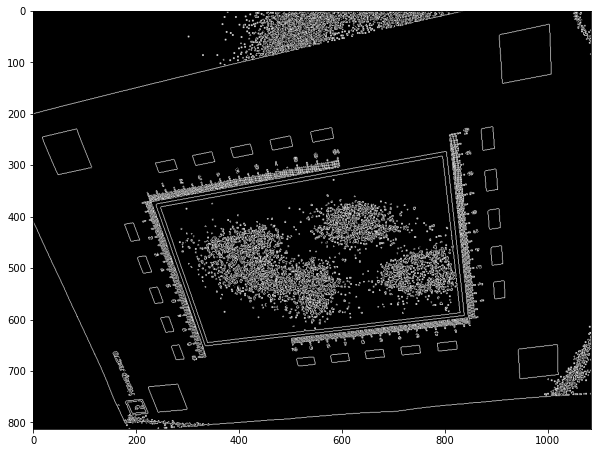

In [182]:
plt.figure(figsize=[10, 10])
plt.imshow(edges, cmap='Greys_r')

## Вопрос 3

Для чего применяется процедура гистерезиса в детекторе Канни? Как влияют на результат пороги гистерезиса?

**Ответ:**

## Выделение контуров

Туториал: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

Для работы с контурами могут быть полезны следующие средства:

1. `cv2.findContours` - поиск контуров
2. `cv2.contourArea` - площадь фигуры, ограниченной контуром
3. `cv2.arcLength` - длина контура
4. `cv2.isContourConvex` - проверка на выпуклость
5. `cv2.approxPolyDP` - аппроксимация контура более простым (состоящим из меньшего числа звеньев)
6. `cv2.drawContours` - отрисовка контуров

In [183]:
contours, hierarchy = cv2.findContours(
    th_otsu,                 # входное изображение, бинаризованное
    cv2.RETR_TREE,           # восстановить иерархию контуров по вложенности друг в друга
    cv2.CHAIN_APPROX_SIMPLE    # не аппроксимировать контуры
)

In [184]:
img_countours = img.copy()
img_countours = cv2.drawContours(img_countours, contours, -1, (255,0,0), 3)
None

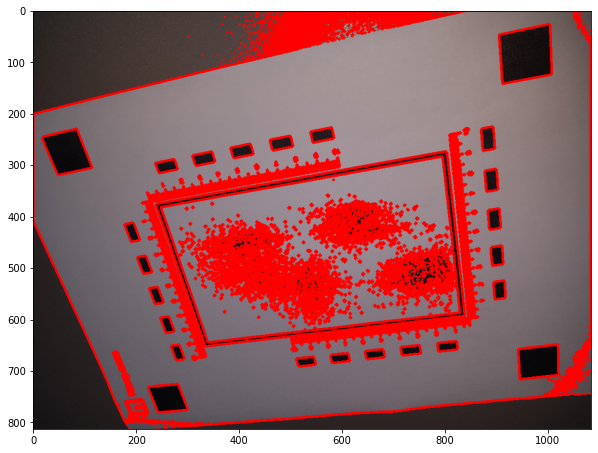

In [185]:
plt.figure(figsize=[10, 10])
plt.imshow(img_countours)

## Вопрос 4

На лекции были рассмотрен методы сопоставления с шаблоном (анализ краев, кросс-корреляция). В нашей задаче тоже есть изображение и шаблон. Оцените применимость этих методов в задаче.

**Ответ:   я считаю, что не возможно, так как очень сильно отличаются изображения и не все изображение входит** 

In [186]:
area_max = img.shape[0] * img.shape[1] / 4
area_min = img.shape[0] * img.shape[1] / 16

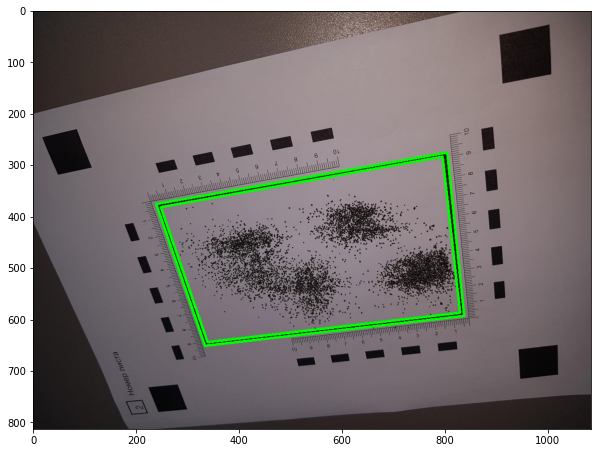

In [196]:
img_countours = img.copy()
for cont in contours:
        #сглаживание и определение количества углов
        sm = cv2.arcLength(cont, True)
        apd = cv2.approxPolyDP(cont, 0.05*sm, True)
        area = cv2.contourArea(cont)
        #выделение контуров
        if len(apd) == 4 and area <= area_max  and area >= area_min :
            img_countours = cv2.drawContours(img_countours , [apd], -1, (0,255,0), 4)
            # print(apd)
            input_pts = apd

plt.figure(figsize=[10, 10])
plt.imshow(img_countours)

In [197]:
import numpy as np

In [198]:
maxHeight = img.shape[0]
maxWidth = img.shape[1]
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])


In [199]:
input_pts[0][0]

array([796, 284], dtype=int32)

In [200]:
input_pts_new = np.float32([input_pts[0][0], input_pts[1][0], input_pts[2][0], input_pts[3][0]])

In [201]:
M = cv2.getPerspectiveTransform(input_pts_new,output_pts)

In [202]:
img_new = img.copy()
out = cv2.warpPerspective(img_new,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

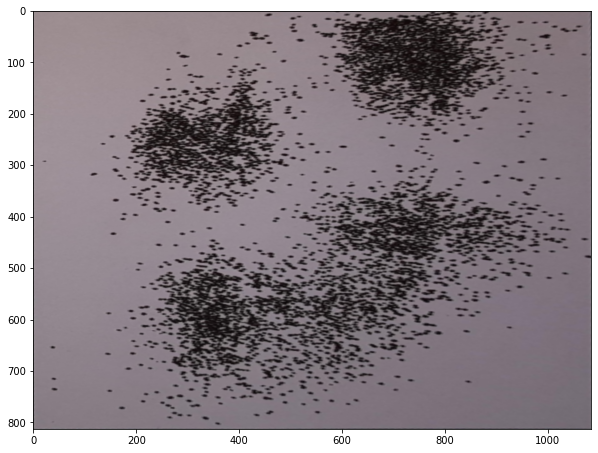

In [203]:
plt.figure(figsize=[10, 10])
plt.imshow(out)

# Задание

Используя средства OpenCV реазизуйте извлечение области с пропаннатом из изображения.

Примечание: возможно, для выполнения задания дополнительно понадобится применить методы подавления шума и гистограмных преобразаваний, которые были рассмотрены на предыдущих семинарах. Для извлечения прямоугольной области понадобится аппарат проективных преобразований, представленный функциями `cv2.getPerspectiveTransform` - по 4 парам соответствующих точек выдает матрицу гомограции, `cv2.warpPerspective` - применяет преобразование гомографии.

### Пример промежуточных результатов

Сначала выделим границы на изображении. К ним будут отнесены границы поисковых узоров в том числе. Но не только они. Кроме того присутствует шум типа "перец". Его можно удалить, но, как дальше было выяснено, это не влияет на качество выделения линий.

Примечание: это не результат работы детектора Canny

In [215]:
# здесь был код

Теперь обнаружим прямоугольники, по полученному бинаризованному изображению с границами:

In [216]:
# здесь был код

Остается выделить целевую область с пропаннатом и произвести выравнивание

In [217]:
# здесь был код